In [1]:
from evaluation import WachterEtAl
import os 
import pandas as pd
import numpy as np
import numpy as np
import pickle
from deap import creator, base
import torch
from evaluation.metrics import redundancy, yNN,yNN_timeseries, d1_distance , d2_distance
import warnings
from tslearn.datasets import UCR_UEA_datasets
from models.ResNet import ResNetBaseline
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin,window=0)

In [2]:
dataset='GunPoint'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])

In [3]:
enc1=pickle.load(open(f'./models/{dataset}/OneHotEncoder.pkl','rb'))
test_y=enc1.transform(test_y.reshape(-1,1))
n_classes = test_y.shape[1]
model = ResNetBaseline(in_channels=1, num_pred_classes=n_classes)
model.load_state_dict(torch.load(f'./models/{dataset}/ResNet'))
model.eval()

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(1, 64, kernel_size=(1,)

In [4]:
y_pred= model(torch.from_numpy(test_x).float()).detach().numpy()
test_y=y_pred

In [5]:
from evaluation.COMTE import AtesCF
from evaluation.Nun_CF import NativeGuideCF
'''Initialize Methods'''
nguide_cf=NativeGuideCF(model,np.array(train_x).shape, (test_x,test_y))
ates= AtesCF(model, (test_x,test_y))

In [6]:
#TODO Validity Calculation, ONLY FOR WACHTER 
'''Calculate'''
ynn=[]
ynn_timeseries=[]
red=[]
sal_01=[]
sal_02=[]
not_valid=0
wachter_cf=[]
ynn_wachter=[]
ynn_timeseries_wachter=[]
red_wachter=[]
sal_01_wachter=[]
sal_02_wachter=[]
not_valid_wachter=0
ynn_cfg=[]
ynn_timeseries_cfg=[]
red_cfg=[]
sal_01_cfg=[]
sal_02_cfg=[]
cfg_cf=[]
not_valid_cfg=0
ynn_ib=[]
ynn_timeseries_ib=[]
red_ib=[]
sal_01_ib=[]
sal_02_ib=[]
ib_cf=[]
not_valid_ib=0
max_iteration=len(test_y)
    #TODO add time Measure
for i, item in enumerate(test_x):
    print('Image Number ',{i})
    observation_01=item
    label_01=np.array([test_y[i]])#test_y[0]
    if os.path.exists( f'./Results/mutate_both/{dataset}/Counterfactuals_{i}.pkl'):
        pop=pickle.load(open( f'./Results/mutate_both/{dataset}/Counterfactuals_{i}.pkl', "rb" ))
    else:
        break
    #input_ = torch.from_numpy(np.array(pop)).float()
    #output = torch.nn.functional.softmax(model(input_)).detach().numpy()
    y_target =np.argmax(test_y[i]) #output.argmax()
    mlmodel = model 
    counterfactuals = pop
    original = observation_01
    #print(y_target)
    #print(counterfactuals[0].output) 
    if y_target == np.argmax(counterfactuals[0].output):
        not_valid=not_valid+1
    ynn.append(yNN(counterfactuals, mlmodel,train_x,5)[0][0])
    ynn_timeseries.append(yNN_timeseries(counterfactuals, mlmodel,train_x,5)[0][0])
    red.append(redundancy(original, counterfactuals, mlmodel)[0])
    sal_01.append(d1_distance(observation_01,np.array(pop)))
    sal_02.append(d2_distance(observation_01,np.array(pop)))
    
    # Wachter et al . 
    #print(item.shape)
    #print(observation_01.shape)
    item = item.reshape(1,item.shape[-2],item.shape[-1])
    wachter_counterfactual, laberl_w=WachterEtAl.wachter_recourse(mlmodel, item, y_target)
    wachter_cf.append(wachter_counterfactual)
    if not wachter_counterfactual is None:
        wachter_couterfactual=wachter_counterfactual.reshape(np.array(pop).shape[0],np.array(pop).shape[1],np.array(pop).shape[2])
        ynn_wachter.append(yNN(wachter_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        ynn_timeseries_wachter.append(yNN_timeseries(wachter_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        red_wachter.append(redundancy(original, wachter_counterfactual, mlmodel,labels=np.array([y_target]))[0])
        sal_01_wachter.append(d1_distance(observation_01,np.array(wachter_counterfactual)))
        sal_02_wachter.append(d2_distance(observation_01,np.array(wachter_counterfactual)))
        if laberl_w == np.argmax(label_01,axis=1):
            not_valid_wachter=not_valid_wachter+1
    else: 
         not_valid_wachter=not_valid_wachter+1
        #Other Approach 

    item = item.reshape(1,item.shape[-2],item.shape[-1])
    cfg_counterfactual,label_cfg=nguide_cf.explain(item,  y_target)#(mlmodel, item, y_target).reshape(np.array(pop).shape[0],np.array(pop).shape[1],np.array(pop).shape[2])
    cfg_cf.append(cfg_counterfactual)
    if not cfg_counterfactual is None:
        print(cfg_counterfactual.shape)
        ynn_cfg.append(yNN(cfg_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        ynn_timeseries_cfg.append(yNN_timeseries(cfg_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        red_cfg.append(redundancy(original, cfg_counterfactual, mlmodel,labels=np.array([y_target]))[0])
        sal_01_cfg.append(d1_distance(observation_01,np.array(cfg_counterfactual)))
        sal_02_cfg.append(d2_distance(observation_01,np.array(cfg_counterfactual)))
        if label_cfg == np.argmax(label_01,axis=1):
            not_valid_cfg=not_valid_cfg+1

    else: 
        not_valid_cfg=not_valid_cfg+1

    #Other 2 
    item = item.reshape(1,item.shape[-2],item.shape[-1])
    reference_set=(train_x,train_y)
    ib_counterfactual,label_ib=nguide_cf.explain(item,  y_target,method='dtw_bary_center')#(mlmodel, item, y_target).reshape(np.array(pop).shape[0],np.array(pop).shape[1],np.array(pop).shape[2])
    ib_cf.append(ib_counterfactual)
    
    if not ib_counterfactual is None:
        ib_counterfactual=ib_counterfactual.reshape(1,1,-1)
        ynn_ib.append(yNN(ib_counterfactual,mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        ynn_timeseries_ib.append(yNN_timeseries(ib_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        red_ib.append(redundancy(original, ib_counterfactual, mlmodel,labels=np.array([y_target]))[0])
        sal_01_ib.append(d1_distance(observation_01,np.array(ib_counterfactual)))
        sal_02_ib.append(d2_distance(observation_01,np.array(ib_counterfactual)))
        if label_ib == np.argmax(label_01,axis=1):
            not_valid_ib=not_valid_ib+1
    else: 
        not_valid_ib=not_valid_ib+1
        
    if i ==19:
        break


pickle.dump(wachter_cf,open(f'./Results/Benchmarking/{dataset}/Wachter_cf.pkl','wb'))
pickle.dump(ib_cf,open(f'./Results/Benchmarking/{dataset}/ib_cf.pkl','wb'))
pickle.dump(cfg_cf,open(f'./Results/Benchmarking/{dataset}/cfg_cf.pkl','wb'))
dis1={}
dis1['Wachter']=sal_01_wachter
dis1['our']=sal_01
dis1['ib']=sal_01_ib
dis1['cfg']=sal_01_cfg
pickle.dump(dis1, open(f'./Results/Benchmarking/{dataset}/Dis1.pkl','wb'))
dis2= {}
dis2['Wachter']=sal_02_wachter
dis2['our']=sal_02
dis2['ib']=sal_02_ib
dis2['cfg']=sal_02_cfg
pickle.dump(dis2, open(f'./Results/Benchmarking/{dataset}/Dis2.pkl','wb'))
#TODO Problems with CF Output
results = pd.DataFrame([])
results['method']=['TS_Evo', 'Wachter', 'NG_DBN', 'NG_GradCam']
#results['ynn']=[np.mean(ynn),np.mean(ynn_wachter),np.mean(ynn_ib),np.mean(ynn_cfg)]
#results['ynn_std']=[np.std(ynn),np.std(ynn_wachter),np.std(ynn_ib),np.std(ynn_cfg)]
results['validity']=[1-not_valid/20, 1-not_valid_wachter/20,1-not_valid_ib/20,1-not_valid_cfg/20]
results['ynn_timeseries']=[np.mean(ynn_timeseries),np.mean(ynn_timeseries_wachter),np.mean(ynn_timeseries_ib),np.mean(ynn_timeseries_cfg)]
results['ynn_timeseries_std']=[np.std(ynn_timeseries),np.std(ynn_timeseries_wachter),np.std(ynn_timeseries_ib),np.std(ynn_timeseries_cfg)]
results['red']=[np.mean(red),np.mean(red_wachter),np.mean(red_ib),np.mean(red_cfg)]
results['red_std']=[np.std(red),np.std(red_wachter),np.std(red_ib),np.std(red_cfg)]
results['sparsity']=[np.mean(sal_01),np.mean(sal_01_wachter),np.mean(sal_01_ib),np.mean(sal_01_cfg)]
results['sparsity_std']=[np.std(sal_01),np.std(sal_01_wachter),np.std(sal_01_ib),np.std(sal_01_cfg)]
results['dis']=[np.mean(sal_02),np.mean(sal_02_wachter),np.mean(sal_02_ib),np.mean(sal_02_cfg)]
results['dis_std']=[np.std(sal_02),np.std(sal_02_wachter),np.std(sal_02_ib),np.std(sal_02_cfg)]
 #results['closest']=sal_02
results.to_csv(f'./Results/Benchmarking/{dataset}/BenchmarkMetrics.csv')

Image Number  {0}


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
results

,method,validity,ynn_timeseries,ynn_timeseries_std,red,red_std,sparsity,sparsity_std,dis,dis_std
0,TS_Evo,1.0,0.94,9.165151e-02,55.600000,56.212454,0.374333,0.379422,2.542433e-01,2.973443e-01
1,Wachter,1.0,0.84,8.000000e-02,150.000000,0.000000,1.000000,0.000000,1.948332e-08,2.684408e-09
2,NG_DBN,0.6,0.80,1.110223e-16,4.750000,6.193074,1.000000,0.000000,8.018234e+07,2.659347e+08
3,NG_GradCam,0.6,0.80,1.110223e-16,4.416667,2.465033,0.191667,0.155733,1.882269e-02,1.573758e-02


In [ ]:
from Paper_Vis_Baselines import build_figure, dis_to_latex_2_Tables, plot_dis, calculate_total_ynn

In [ ]:
build_figure()

NameError: name 'build_figure' is not defined

authentic_opposing_information/CBF
authentic_opposing_information/ECG5000
authentic_opposing_information/FordA
authentic_opposing_information/Coffee
authentic_opposing_information/ElectricDevices
authentic_opposing_information/GunPoint
authentic_opposing_information/NATOPS
authentic_opposing_information/UWaveGestureLibrary
frequency_band_mapping/CBF
frequency_band_mapping/ECG5000
frequency_band_mapping/FordA
frequency_band_mapping/Coffee
frequency_band_mapping/ElectricDevices
frequency_band_mapping/GunPoint
frequency_band_mapping/NATOPS
frequency_band_mapping/UWaveGestureLibrary
mutate_mean/CBF
mutate_mean/NATOPS
mutate_mean/UWaveGestureLibrary
mutate_mean/ECG5000
mutate_mean/Coffee
mutate_mean/ElectricDevices
mutate_mean/GunPoint
mutate_mean/FordA
mutate_both/CBF
mutate_both/NATOPS
mutate_both/UWaveGestureLibrary
mutate_both/ECG5000
mutate_both/Coffee
mutate_both/ElectricDevices
mutate_both/GunPoint
mutate_both/FordA
dict_keys(['authentic_opposing_information', 'frequency_band_mapping

<Figure size 2160x2160 with 0 Axes>

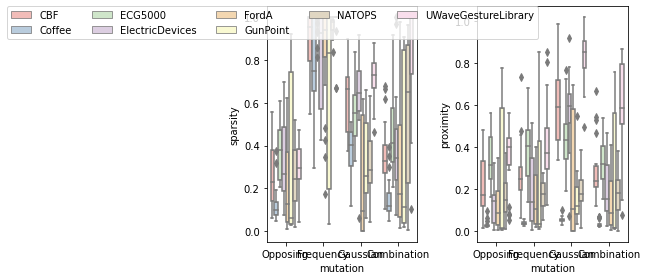

In [1]:
from PaperEval import build_figure_mut, plot_l1_l2
from matplotlib import interactive
interactive(True)
    #calculate_full_ynn(True, True)
#build_figure_mut()
#TODO rewrite Plot so that logs are taken 
#
import matplotlib.pyplot as plt
plt.ion()
plot_l1_l2(True, False)
#calculate_full_ynn(True, True)
#plt.show()